In [1]:
!pip install transformers

In [ ]:
!pip install pandas


In [2]:
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv
# 这是一个三分类推特文章数据集，包括消极，中立，积极，已经打好标签

--2024-02-29 09:56:09--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  12.3MB/s    in 0.3s    

2024-02-29 09:56:10 (12.3 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [4]:
from transformers import pipeline
import numpy as np
import pandas as pd

import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [5]:
# Basic Usage
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [6]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [7]:
classifier("No shit!")

[{'label': 'POSITIVE', 'score': 0.9666265845298767}]

In [8]:
classifier("shit!")

[{'label': 'NEGATIVE', 'score': 0.9978773593902588}]

In [10]:
import torch

print(torch.cuda.is_available())

True


In [11]:
print(torch.cuda.current_device())



0


In [12]:
classifier = pipeline("sentiment-analysis", device = 0)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [13]:
df_ = pd.read_csv('AirlineTweets.csv')
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [14]:
df = df_[['airline_sentiment','text']]# 选择需要的列

<Axes: >

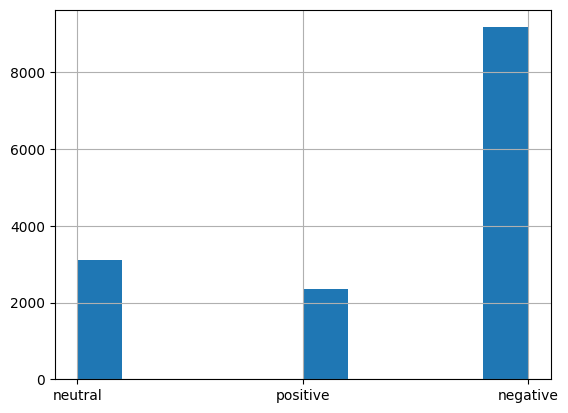

In [15]:
df['airline_sentiment'].hist()

In [16]:
df = df[df.airline_sentiment != 'neutral'].copy()#过滤掉所有中立评论

In [17]:
target_map = {'positive':1,'negative':0}#映射

df['target'] = df['airline_sentiment'].map(target_map)




* target_map 是一个Python字典，它定义了一个从字符串标签到数值标签的映射。在这个映射中，字符串 'positive' 被映射到数值 1，字符串 'negative' 被映射到数值 0。

* df 是一个Pandas的DataFrame对象，它是一个二维标签数据结构，可以非常方便地处理和分析数据。

* df['airline_sentiment'] 是df DataFrame中的一列，其中包含了航空公司的情感评价，它们是字符串形式的，如 'positive' 或 'negative'。

* .map(target_map) 是Pandas中的一个函数，它将 target_map 字典应用于 df['airline_sentiment'] 列。这意味着该列中的每个条目都会根据 target_map 字典进行转换：所有 'positive' 的条目都将变为 1，所有 'negative' 的条目都将变为 0。

* df['target'] 创建了一个新列 'target' 在DataFrame df 中，并将 .map() 函数的结果赋值给它。最终结果是一个新的数值列，代表了原来 airline_sentiment 字符串标签的编码形式。

In [18]:
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [19]:
len(df)

11541

In [20]:
texts = df['text'].tolist()# 将一列转化为一行文本的集合
predictions  =classifier(texts)

In [ ]:
predictions


In [22]:
probs = [d['score'] if d['label'].startswith('P') else 1-d['score'] for d in predictions] #将prediction中的score列转化为靠近1为positive，靠近0为negative

In [23]:
probs

[0.6070840954780579,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553212523460388,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957,
 0.9996304512023926,
 0.001948714256286621,
 0.9964436888694763,
 0.0031333565711975098,
 0.9787647724151611,
 0.9995218515396118,
 0.004548370838165283,
 0.9995624423027039,
 0.9998748302459717,
 0.004880666732788086,
 0.00040477514266967773,
 0.0006322264671325684,
 0.015428304672241211,
 0.01828092336654663,
 0.0004482865333557129,
 0.0023748278617858887,
 0.9934480786323547,
 0.9976067543029785,
 0.8661719560623169,
 0.0003237724304199219,
 0.8415618538856506,
 0.0032317638397216797,
 0.9997846484184265,
 0.1761431097984314,
 0.9993895292282104,
 0.09156662225723267,
 0.004861712455749512,
 0.9997820258140564,
 0.0014235973358154297,
 0.004673957824707031,
 0.00464242696762085,
 0.019041001796722412,
 0.991169810295105,
 0.0125504732131958,
 0.00809931755065918,
 0.99

In [25]:
preds = [1 if d['label'].startswith('P') else 0 for d in predictions ]

In [26]:
preds = np.array(preds)
print("acc:",np.mean(df['target']==preds))

acc: 0.8898708950697514


In [27]:
cm = confusion_matrix(df['target'],preds,normalize='true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

在机器学习中，尤其是在分类任务上，混淆矩阵（Confusion Matrix）是一个非常重要的性能评估工具。情感分析模型，作为一个分类模型的例子（通常是二分类，将情感分为正面或负面），同样可以通过混淆矩阵来评估其性能。

混淆矩阵提供了以下关键信息：

真正类（True Positives, TP）：模型正确预测为正类的实例数。
假正类（False Positives, FP）：模型错误预测为正类的实例数。
真负类（True Negatives, TN）：模型正确预测为负类的实例数。
假负类（False Negatives, FN）：模型错误预测为负类的实例数。
通过这四个基本的度量，可以计算出更多的性能指标，如准确度（Accuracy）、精确率（Precision）、召回率（Recall）和F1分数。这些指标能够提供比简单的准确度更全面的模型性能评估：

准确度告诉我们模型正确预测的实例占总实例的比例。
精确率是模型预测为正类的实例中实际为正类的比例。
召回率是模型正确预测为正类的实例占所有实际正类实例的比例。
F1分数是精确率和召回率的调和平均，用于在两者之间提供一个平衡的性能度量。
在情感分析中，计算混淆矩阵尤为重要，因为它可以揭示模型在预测不同类别时的偏差。例如，模型可能倾向于将多数实例预测为正面情感，而忽视了负面情感的准确预测。这种情况下，即使准确度看起来很高，模型的实际性能也可能并不理想，因为它在负面情感上的假负类（FN）可能很高。混淆矩阵能够帮助我们识别这样的问题，并进行更细致的性能分析。

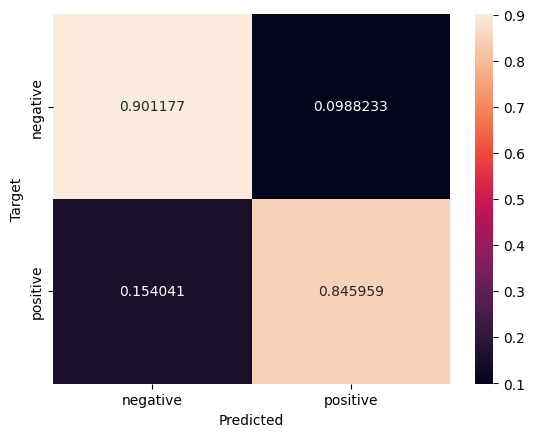

In [28]:
# plot confusion matrix
def plot_cm(cm):
  classes = ["negative","positive"]
  df_cm = pd.DataFrame(cm,index = classes,columns = classes)
  ax = sn.heatmap(df_cm,annot = True,fmt = 'g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

In [29]:
f1_score(df['target'],preds)

0.7587777566900741

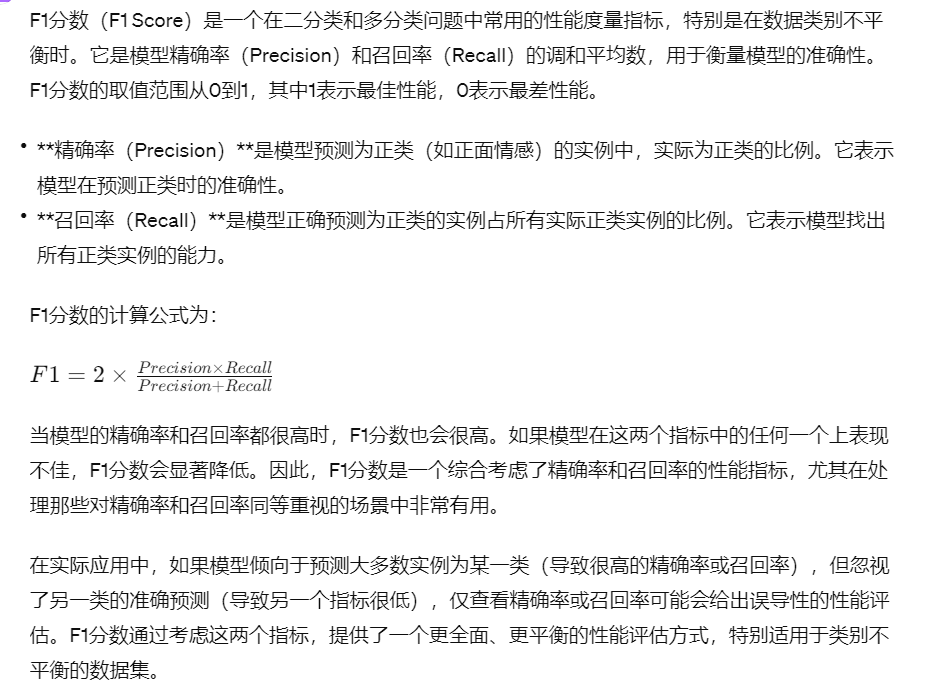

In [30]:
roc_auc_score(df['target'],probs)

0.9485934690648773

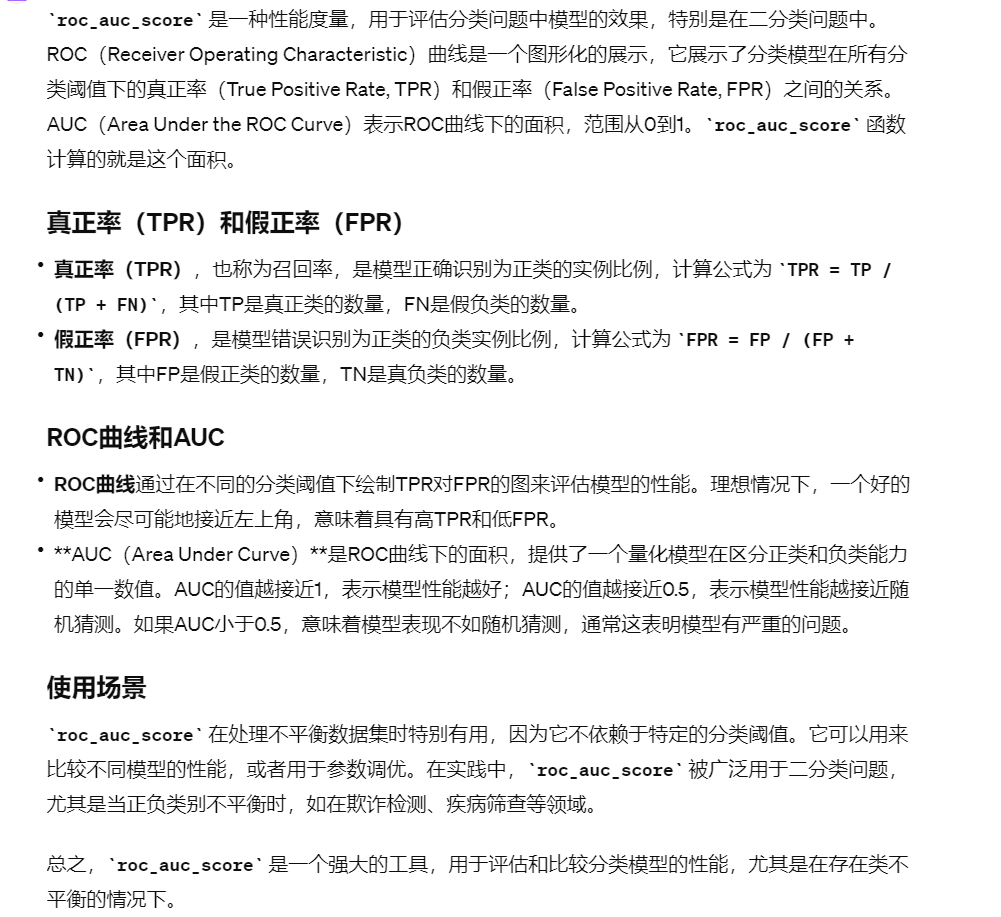